# Figure 4a

In [60]:
import os
import random
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import selfies as sf
from sklearn.metrics import average_precision_score

In [61]:
run_dir = "/rds/general/user/ssh22/home/FS-Tox/multirun/2023-08-16/15-09-01"
base_dir = "/rds/general/user/ssh22/home/FS-Tox"
checkpoint = "ncfrey/ChemGPT-4.7M"
model_dir = "/rds/general/user/ssh22/home/FS-Tox/models"

In [62]:
def average_weights(models):
    # Get model weights
    weight_list = [model.state_dict() for model in models]
    averaged_weights = {}
    for key in weight_list[0]:
        # Average the weights
        summed_weights = sum([weight[key] for weight in weight_list])
        averaged_weights[key] = summed_weights / len(weight_list)
    return averaged_weights

In [63]:
def load_data(task_filepath):
    
    # Load a task
    task = pd.read_parquet(task_filepath)
    
    ratio = task['ground_truth'].sum() / len(task)

    # Convert canonical SMILES to SELFIES
    selfies = task["canonical_smiles"].apply(convert_canonical_smiles_to_selfies)

    # Split task into support and query sets
    support_selfies = selfies[task["support_query"] == 0].tolist()
    query_selfies = selfies[task["support_query"] == 1].tolist()

    # Get support and query labels
    support_labels = torch.tensor(task["ground_truth"][task["support_query"] == 0].reset_index(drop=True))
    query_labels = torch.tensor(task["ground_truth"][task["support_query"] == 1].reset_index(drop=True))
    
    return support_selfies, support_labels, query_selfies, query_labels, ratio

In [64]:
def tokenize_data(data):

    # Tokenize the SELFIES
    return tokenizer(
        data, padding=True, truncation=True, return_tensors="pt", max_length=256
    )

In [65]:
# Create a PyTorch dataset for each task
class ChemDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [66]:
def finetune_model(support_dataset, query_dataset, model, model_path):
    
    # Define Trainer
    args = TrainingArguments(
        output_dir=model_path,
        evaluation_strategy="steps",
        eval_steps=500,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        seed=0,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=support_dataset,
        eval_dataset=query_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    
    trainer.save_model(model_path)

In [67]:
def generate_predictions(model, query_dataset, ratio):

    # Define test trainer
    trainer = Trainer(model)

    # Make prediction
    raw_pred, _, _ = trainer.predict(query_dataset)
    
    # Assuming true_labels is a numpy array containing the ground truth labels for query_dataset
    true_labels = np.array(query_dataset.labels)

    # Compute the probabilities for the positive class
    y_prob = raw_pred[:, 1]
    
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute AUC-PR
    return average_precision_score(true_labels, y_prob) - ratio

In [68]:
def compute_metrics(p):
    pred, labels = p
    auc_pr = average_precision_score(y_true=labels, y_pred=pred)
    
    return {"auc_pr": auc_pr}

In [69]:
def convert_canonical_smiles_to_selfies(smiles_str):
    # Convert SMILES to SELFIES
    selfies_str = sf.encoder(smiles_str)
    return selfies_str

## Predictions on MEIC - no transfer learning

## Predictions on MEIC - in-vivo transfer learning

## Predictions on MEIC 

## Predictions on toxval - no transfer learning

## Predictions on toxval - transfer learning

## Predictions on aot - no transfer learning

## Predictions on aot - transfer learning

# Figure 4b

In [70]:
def load_model(path):
    return AutoModelForSequenceClassification.from_pretrained(path, num_labels=2)

In [71]:
res = {}

## No pre-training

In [72]:
# Tokenize the SELFIES
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Adding a padding token
tokenizer.pad_token = "[PAD]"

In [73]:
finetuned_auc_pr = []

In [74]:
dataset_dir = f"{base_dir}/multirun/2023-08-16/15-09-01/params.dataset=meic,params.feature=ecfp4_1024/data/processed/task"
tasks = [f"{dataset_dir}/{task}" for task in os.listdir(dataset_dir)]

In [75]:
dataset = "meic"
print(dataset, ": beginning training")
for task in tqdm(tasks):
    # Load data
    support_selfies, support_labels, query_selfies, query_labels, ratio = load_data(task)

    # Tokenize data
    support_encodings = tokenize_data(support_selfies)
    query_encodings = tokenize_data(query_selfies)

    # Create support and query data 
    support_dataset = ChemDataset(support_encodings, support_labels)
    query_dataset = ChemDataset(query_encodings, query_labels)

    # Get the finetuned model
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
    finetuned_model.config.pad_token_id = tokenizer.pad_token_id

    # Get task_id
    task_id = os.path.splitext(os.path.basename(task))[0]

    # Set finetuned model path
    model_path = os.path.join(model_dir, dataset, task_id)

    # Finetune model
    finetune_model(support_dataset, query_dataset, finetuned_model, model_path)

    # Load baseline and finetuned models 
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
    finetuned_model.config.pad_token_id = tokenizer.pad_token_id

    # Generate predictions
    finetune_auc = generate_predictions(finetuned_model, query_dataset, ratio)
    finetuned_auc_pr.append(finetune_auc)

meic : beginning training


  0%|          | 0/18 [00:00<?, ?it/s]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


  6%|▌         | 1/18 [00:02<00:38,  2.27s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 11%|█         | 2/18 [00:04<00:33,  2.10s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 17%|█▋        | 3/18 [00:05<00:27,  1.85s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 22%|██▏       | 4/18 [00:07<00:26,  1.91s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 28%|██▊       | 5/18 [00:09<00:23,  1.79s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 33%|███▎      | 6/18 [00:11<00:22,  1.87s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 39%|███▉      | 7/18 [00:13<00:20,  1.87s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 44%|████▍     | 8/18 [00:15<00:18,  1.83s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 50%|█████     | 9/18 [00:17<00:17,  1.90s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 56%|█████▌    | 10/18 [00:18<00:14,  1.81s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 61%|██████    | 11/18 [00:20<00:12,  1.75s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 67%|██████▋   | 12/18 [00:22<00:11,  1.84s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 72%|███████▏  | 13/18 [00:23<00:08,  1.76s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 78%|███████▊  | 14/18 [00:25<00:07,  1.82s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 83%|████████▎ | 15/18 [00:27<00:05,  1.74s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 89%|████████▉ | 16/18 [00:29<00:03,  1.81s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 94%|█████████▍| 17/18 [00:31<00:01,  1.86s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


100%|██████████| 18/18 [00:33<00:00,  1.85s/it]


In [76]:
res['none'] = np.median(finetuned_auc_pr)

## In-vitro

In [77]:
# Get a list of in-vitro models
in_vitro_datasets = ["toxcast", "prism", "nci60", "cancerrx"]
in_vitro_dataset_filepaths = [f"{base_dir}/models/{dataset}" for dataset in in_vitro_datasets]

In [78]:
# Average the weights
def average_weights(models):
    # Get model weights
    weight_list = [model.state_dict() for model in models]
    averaged_weights = {}
    for key in weight_list[0]:
        # Average the weights
        summed_weights = sum([weight[key] for weight in weight_list])
        averaged_weights[key] = summed_weights / len(weight_list)
    return averaged_weights

In [79]:
in_vitro_models = []

for d in tqdm(in_vitro_dataset_filepaths):
    paths = [f"{d}/{path}" for path in os.listdir(d)]
    models = [load_model(path) for path in paths]
    averaged_weights = average_weights(models)
    combined_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
    combined_model.load_state_dict(averaged_weights)
    in_vitro_models.append(combined_model)

averaged_weights = average_weights(in_vitro_models)
combined_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
combined_model.load_state_dict(averaged_weights)

# Save the final combined model
combined_model.save_pretrained(f"{base_dir}/final_models/in_vitro_model")

  0%|          | 0/4 [00:00<?, ?it/s]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 1/4 [01:10<03:31, 70.37s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|█████     | 2/4 [02:25<02:26, 73.41s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 75%|███████▌  | 3/4 [03:43<01:15, 75.39s/it]Some weig

In [80]:
in_vitro_finetuned_auc_pr = []
in_vitro_checkpoint = f"{base_dir}/final_models/in_vitro_model"

# Train on support sets and predict on query sets
dataset = "meic"
print(dataset, ": beginning training")
for task in tqdm(tasks):
    # Load data
    support_selfies, support_labels, query_selfies, query_labels, ratio = load_data(task)

    # Tokenize data
    support_encodings = tokenize_data(support_selfies)
    query_encodings = tokenize_data(query_selfies)

    # Create support and query data 
    support_dataset = ChemDataset(support_encodings, support_labels)
    query_dataset = ChemDataset(query_encodings, query_labels)

    # Get the finetuned model
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(in_vitro_checkpoint, num_labels=2)
    finetuned_model.config.pad_token_id = tokenizer.pad_token_id

    # Get task_id
    task_id = os.path.splitext(os.path.basename(task))[0]

    # Set finetuned model path
    model_path = os.path.join(model_dir, dataset, task_id)

    # Finetune model
    finetune_model(support_dataset, query_dataset, finetuned_model, model_path)

    # Load baseline and finetuned models 
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
    finetuned_model.config.pad_token_id = tokenizer.pad_token_id

    # Generate predictions
    finetune_auc = generate_predictions(finetuned_model, query_dataset, ratio)
    in_vitro_finetuned_auc_pr.append(finetune_auc)

meic : beginning training


  0%|          | 0/18 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


  6%|▌         | 1/18 [00:02<00:34,  2.01s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 11%|█         | 2/18 [00:04<00:36,  2.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 17%|█▋        | 3/18 [00:06<00:31,  2.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 22%|██▏       | 4/18 [00:08<00:31,  2.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 28%|██▊       | 5/18 [00:10<00:28,  2.16s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 33%|███▎      | 6/18 [00:13<00:26,  2.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 39%|███▉      | 7/18 [00:15<00:23,  2.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 44%|████▍     | 8/18 [00:17<00:21,  2.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 50%|█████     | 9/18 [00:19<00:19,  2.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 56%|█████▌    | 10/18 [00:21<00:17,  2.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 61%|██████    | 11/18 [00:23<00:14,  2.10s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 67%|██████▋   | 12/18 [00:26<00:13,  2.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 72%|███████▏  | 13/18 [00:28<00:10,  2.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 78%|███████▊  | 14/18 [00:30<00:08,  2.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 83%|████████▎ | 15/18 [00:32<00:06,  2.18s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 89%|████████▉ | 16/18 [00:35<00:04,  2.26s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 94%|█████████▍| 17/18 [00:37<00:02,  2.32s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


100%|██████████| 18/18 [00:39<00:00,  2.22s/it]


In [81]:
res['in-vitro'] = np.median(in_vitro_finetuned_auc_pr)

## In vivo

In [82]:
# Get a list of in-vivo models
in_vivo_datasets = ["toxval", "acute_oral_toxicity"]
in_vivo_dataset_filepaths = [f"{base_dir}/models/{dataset}" for dataset in in_vivo_datasets]

In [83]:
# Average the weights
in_vivo_models = []

for d in tqdm(in_vivo_dataset_filepaths):
    paths = [f"{d}/{path}" for path in os.listdir(d)]
    models = [load_model(path) for path in paths]
    averaged_weights = average_weights(models)
    combined_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
    combined_model.load_state_dict(averaged_weights)
    in_vivo_models.append(combined_model)

averaged_weights = average_weights(in_vivo_models)
combined_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
combined_model.load_state_dict(averaged_weights)

# Save the final combined model
combined_model.save_pretrained(f"{base_dir}/final_models/in_vivo_model")

  0%|          | 0/2 [00:00<?, ?it/s]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|█████     | 1/2 [01:09<01:09, 69.10s/it]Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2/2 [01:13<00:00, 36.76s/it]
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
# Train on support sets
in_vivo_finetuned_auc_pr = []
in_vivo_checkpoint = f"{base_dir}/final_models/in_vivo_model"

# Train on support sets and predict on query sets
dataset = "meic"
print(dataset, ": beginning training")
for task in tqdm(tasks):
    # Load data
    support_selfies, support_labels, query_selfies, query_labels, ratio = load_data(task)

    # Tokenize data
    support_encodings = tokenize_data(support_selfies)
    query_encodings = tokenize_data(query_selfies)

    # Create support and query data 
    support_dataset = ChemDataset(support_encodings, support_labels)
    query_dataset = ChemDataset(query_encodings, query_labels)

    # Get the finetuned model
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(in_vivo_checkpoint, num_labels=2)
    finetuned_model.config.pad_token_id = tokenizer.pad_token_id

    # Get task_id
    task_id = os.path.splitext(os.path.basename(task))[0]

    # Set finetuned model path
    model_path = os.path.join(model_dir, dataset, task_id)

    # Finetune model
    finetune_model(support_dataset, query_dataset, finetuned_model, model_path)

    # Load baseline and finetuned models 
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
    finetuned_model.config.pad_token_id = tokenizer.pad_token_id

    # Generate predictions
    finetune_auc = generate_predictions(finetuned_model, query_dataset, ratio)
    in_vivo_finetuned_auc_pr.append(finetune_auc)

meic : beginning training


  0%|          | 0/18 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


  6%|▌         | 1/18 [00:01<00:26,  1.54s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 11%|█         | 2/18 [00:03<00:28,  1.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 17%|█▋        | 3/18 [00:04<00:24,  1.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 22%|██▏       | 4/18 [00:06<00:24,  1.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 28%|██▊       | 5/18 [00:08<00:21,  1.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 33%|███▎      | 6/18 [00:10<00:21,  1.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 39%|███▉      | 7/18 [00:11<00:18,  1.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 44%|████▍     | 8/18 [00:13<00:16,  1.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 50%|█████     | 9/18 [00:15<00:15,  1.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 56%|█████▌    | 10/18 [00:16<00:13,  1.65s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 61%|██████    | 11/18 [00:18<00:11,  1.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 67%|██████▋   | 12/18 [00:20<00:10,  1.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 72%|███████▏  | 13/18 [00:21<00:08,  1.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 78%|███████▊  | 14/18 [00:23<00:06,  1.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 83%|████████▎ | 15/18 [00:25<00:04,  1.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 89%|████████▉ | 16/18 [00:27<00:03,  1.74s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 94%|█████████▍| 17/18 [00:29<00:01,  1.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


100%|██████████| 18/18 [00:30<00:00,  1.72s/it]


In [85]:
res['in-vivo'] = np.median(in_vivo_finetuned_auc_pr)

## In-vitro + in-vivo

In [86]:
final_model_filepaths = [f"{base_dir}/final_models/{d}" for d in os.listdir(f"{base_dir}/final_models")]

In [87]:
# Combine the in-vivo and in-vitro models
final_models = []

models = [load_model(path) for path in final_model_filepaths]
averaged_weights = average_weights(models)
combined_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
combined_model.load_state_dict(averaged_weights)

# Save the final combined model
combined_model.save_pretrained(f"{base_dir}/final_models/combined_model")

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
# Train on support sets
combined_finetuned_auc_pr = []
combined_checkpoint = f"{base_dir}/final_models/combined_model"

# Train on support sets and predict on query sets
dataset = "meic"
print(dataset, ": beginning training")
for task in tqdm(tasks):
    # Load data
    support_selfies, support_labels, query_selfies, query_labels, ratio = load_data(task)

    # Tokenize data
    support_encodings = tokenize_data(support_selfies)
    query_encodings = tokenize_data(query_selfies)

    # Create support and query data 
    support_dataset = ChemDataset(support_encodings, support_labels)
    query_dataset = ChemDataset(query_encodings, query_labels)

    # Get the finetuned model
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(in_vivo_checkpoint, num_labels=2)
    finetuned_model.config.pad_token_id = tokenizer.pad_token_id

    # Get task_id
    task_id = os.path.splitext(os.path.basename(task))[0]

    # Set finetuned model path
    model_path = os.path.join(model_dir, dataset, task_id)

    # Finetune model
    finetune_model(support_dataset, query_dataset, finetuned_model, model_path)

    # Load baseline and finetuned models 
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
    finetuned_model.config.pad_token_id = tokenizer.pad_token_id

    # Generate predictions
    finetune_auc = generate_predictions(finetuned_model, query_dataset, ratio)
    combined_finetuned_auc_pr.append(finetune_auc)

meic : beginning training


  0%|          | 0/18 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


  6%|▌         | 1/18 [00:01<00:25,  1.50s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 11%|█         | 2/18 [00:03<00:28,  1.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 17%|█▋        | 3/18 [00:04<00:24,  1.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 22%|██▏       | 4/18 [00:06<00:24,  1.73s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 28%|██▊       | 5/18 [00:08<00:21,  1.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 33%|███▎      | 6/18 [00:10<00:20,  1.73s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 39%|███▉      | 7/18 [00:11<00:18,  1.65s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 44%|████▍     | 8/18 [00:13<00:15,  1.59s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 50%|█████     | 9/18 [00:15<00:15,  1.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 56%|█████▌    | 10/18 [00:16<00:12,  1.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 61%|██████    | 11/18 [00:17<00:11,  1.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 67%|██████▋   | 12/18 [00:19<00:10,  1.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 72%|███████▏  | 13/18 [00:21<00:08,  1.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 78%|███████▊  | 14/18 [00:23<00:06,  1.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 83%|████████▎ | 15/18 [00:24<00:04,  1.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 89%|████████▉ | 16/18 [00:26<00:03,  1.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


 94%|█████████▍| 17/18 [00:28<00:01,  1.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


100%|██████████| 18/18 [00:30<00:00,  1.69s/it]


In [89]:
res['combined'] = np.median(in_vivo_finetuned_auc_pr)

## Make plot

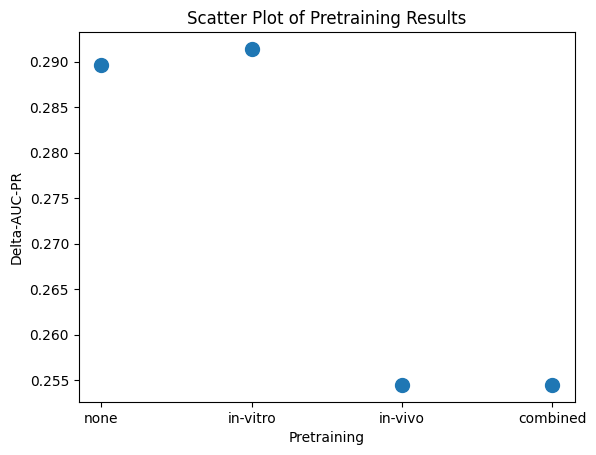

In [90]:
# Scatter plot
fig, ax = plt.subplots()

# Scatter plot data
x = list(res.keys())
y = list(res.values())
ax.scatter(x, y, s=100)

ax.set_title('Scatter Plot of Pretraining Results')
ax.set_xlabel('Pretraining')
ax.set_ylabel('Delta-AUC-PR')

plt.show()